Which College Class Should I Take?
====================

*Note: This blog is an adaptation of a project I completed with a team for an Artificial Intelligence class in May 2019.*

Halfway through each semester, Oberlin College students must pick 4-5 classes out of hundreds of classes offered by over 80 separate departments to take in the following term. These classes determine everything from how quickly a student can complete their major, future jobs, and even lifelong friends. Thus, this is a high pressure and momentous decision.

Frustrated with the clunky tool provided by the school to explore classes, a group of seven students created OPrestissimo during January 2012. OPrestissimo compiles information about classes, including requirements, prerequisites, and teachers, into a single, easily accessible website with a user-friendly interface. Students save classes into a virtual shopping cart, and can look at their potential schedule of classes on a different page without committing to them.

### Goal

Eight years later, OPrestissimo is still going strong. Our goal is to see if machine learning, specifically the apriori algorithm, can help us predict which classes a student should take based on the other classes in their cart. We'll use Python Pandas and Matplotlib to analyze and transform our data.

For this project, we are working with two files: *carts.csv* and *courses.csv*. The former contains a list of students’ “carts” of courses from Fall 2012 to Spring 2018, and the latter contains information about each course.

Let’s start with *carts.csv*.
For each cart, we have the following features:
* id  — a unique identifier for each entry 
* cart_id — a unique identifier for each cart 
* created_at — time the cart was created
* updated_at — time the cart was last updated
* total_credits — total number of college credits each cart contained
* courses — a space separated list of courses in the cart

At this point, it’s hard to tell what the difference between *id* and *cart_id*, and whether either of those features contain useful information. All we know is that no two carts have the same id and cart id. Of the available features, *courses* looks the most interesting. 

But first, let’s take a quick look at our data:


In [5]:
import pandas as pd

path = "/Users/Eliana/Documents/_csprojects/OPrestissimoModels/data/"

carts_df = pd.read_csv(path+'carts.csv')
carts_df.shape

(279565, 6)

The *shape* property of a Pandas DataFrame tells us how many rows and columns our data contains. In this case, we learn that there are 279,565 individual cart entries and six columns (one column for each feature).  Wow, that’s a lot!

#### Feature Selection

##### Do cart_id and id contain useful information?

To understand whether *cart_id* and *id* contain useful information, let’s do some back-of-the-envelope calculations. We know that roughly 3,000 students attend Oberlin College at any given time. Our dataset contains 12 semesters’ worth of information. We know that OPrestissimo was popular, but not every student used it. Let’s say, generously, that 50% of Oberlin students used the website in a given semester. 

279,565 cart entries ÷ (3,000 students × 12 semesters) = 15.5, or about 15.5 entries per student per semester. 

This means that for every student, there are at least 15 unique *cart_id*’s and *id*’s. There’s not much I can do with that information, so it makes sense to ignore *cart_id* and *id*. 

Upon investigation, my team and I learned that OPrestissimo can only hold one cart at a time per logged in user. It was unclear to us under what circumstances OPrestissimo saved an entry, but clearly at least several times per semester. 


##### What about the other features?

Students must delete all the courses in their carts each semester before adding new courses, which means that we cannot track which classes students planned to take over time. That means that *created_at* and *updated_at* are probably not very useful for us. We can safely ignore them. 

We are left with two features: *total_credits* and *courses*.  Courses contains a space-separated list of individual classes, and total_credits gives us an idea of how many classes a student was considering. 

Let's drop those features.

In [6]:
clean_carts = carts_df.drop(columns=['id','cartid','created_at','updated_at'])

##### Feature — total_credits

Usually, Oberlin students take between 14 and 22 credits per semester. Given that a student using OPrestissimo would be considering their options and thus have more credits in their carts, we shouldn’t be surprised if we see more credits than that. Let’s plot a histogram of the total credits to see how many credits were in each cart. 

Text(0.5, 0, 'Number of Credits')

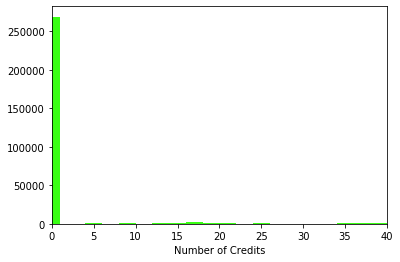

In [7]:
import matplotlib.pyplot as plt

total_credits = clean_carts["total_credits"].tolist() #just retrieve total_credits column, and convert a form matplotlib understands

n, bins, patches = plt.hist(total_credits, bins=[0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,400], histtype='stepfilled',color='#39ff14')
plt.xlim(0, 40)
plt.xlabel("Number of Credits")

Wow, look at all those carts that have less than or equal to 1 total credits! That’s over 250,000 entries, most of our data. Let’s get rid of every entry that has less than one total credits. We can do this easily using pandas filtering, as seen in the code below. 

In [8]:
#make a new DataFrame with entries that have total_credits greater than 1
clean_carts = clean_carts[clean_carts['total_credits']>1]
clean_carts.shape

(10535, 2)

Luckily, we still have over 10,000 entries with usable data. Let’s look at the distribution of total credits, again.

Text(0.5, 0, 'Number of Credits')

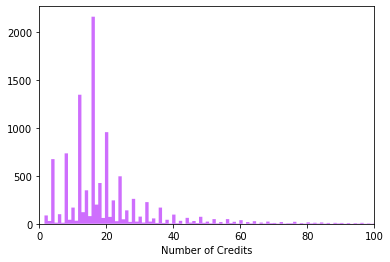

In [9]:
#MAKE A PRETTIER GRAPH
total_credits = clean_carts["total_credits"].tolist()
n,bins,patches = plt.hist(total_credits, bins='fd', histtype='stepfilled', color='#ce6efd')
plt.xlim(0, 100) #100 is best
plt.xlabel("Number of Credits")


That looks much better. Most students had between 2 and 40 credits in their carts, with a right tail of students who added many, many classes. 

##### Feature — Courses

Courses are represented as a space-separated list of classes. We need to clean the data a little bit before we can move on. Each class is represented by a string containing the semester and a registrar code called the “CRN”. For example, a class represented by “s15_17875” represents a class that was offered in Spring 2015 and has the CRN 17875. Each CRN is unique to each section of a class, and the CRNs change semester to semester. This presents a problem. We know that many classes are offered multiple times within a semester and again in later semesters, and we want to maximize the power of our recommendation engine.

This is where our other file *courses.csv* comes in. This file contains tons of information about each class that was offered at Oberlin and stored by OPrestissimo. (Feel free to play with it on your own!)

Let’s look at *dept, cnum*, and *semcrn*. 

In [10]:
#Note: we have about 3 lines of bad data, but it shouldn't affect our analysis very much
courses_df = pd.read_csv(path+"courses.csv", dtype='str',error_bad_lines=False, warn_bad_lines=False)
courses_df[["dept", "cnum", "semcrn"]].head(1)

,dept,cnum,semcrn
0,AAST,101,f09_1002


AAST is the 4-digit code that stands for Africana Studies, 101 is the department’s course number the class, and f09_1002 “semcrn” looks exactly like the entries in our “courses” column in our carts DataFrame. While the semester CRN changes every semester, the department and associated 3-digit code rarely change. This means that we can map the temporary semester CRNs stored in our carts to a more permanent format.

In order to use the apriori algorithm, we need all of our carts in the format of a list of lists. For example, if one student took Africana Studies 101 and Economics 101, and another student just took Economics 101, then our complete list of carts would look like:

In [2]:
[['AAST_101', 'ECON_101'],['ECON_101']]

[['AAST_101', 'ECON_101'], ['ECON_101']]

So we'll create a list of lists of the department abbreviation followed by the department's 3-digit code for the class. 

But before we move on, let's remove any rows that have missing values in the courses column, because we don't care about any carts without any classes.

In [19]:
clean_carts = clean_carts.dropna(subset=['courses']);

Here's a function to reformat the carts. It takes a few minutes to run, so be prepared to wait if you want to try it on your own. First, I clean the items in the cart. Then, for every item in the cart, I check to see if I've already created and saved the abbreviation into *abb_map* and if not, finds it. I re-create each cart as lists of abbreviations, and then append it to my cart of carts, *carts_lists*.

In [23]:
import re

carts_lists = []
abb_map = {} #abbreviation map that maps the sem_crns to the new format (ex: 's12_12434' : 'ATHL_200')

def get_dept_nums(row):
    '''
    Converts sem_crns to a less changeable format, dept_cnum. 
    Ex: 's12_1234' to 'ECON_101'
    
    Arguments:
        row - a row of pandas DataFrame. 
    '''
    
    #clean each item in cart (row is each cart, and ends with a '\n')
    sem_crns = row["courses"]
    clean_courses = str(sem_crns[:-1])
    re.sub('[^A-Za-z0-9]+', '', clean_courses)
    course_list = clean_courses.split(" ")

    deptcrn_cart = []
    for course in course_list:
        if course in abb_map.keys():
            dept_cnum = abb_map[course]
        else:
            #find row in 'courses_df' that has the 'semcrn' present in the cart
            df = courses_df.loc[courses_df['semcrn'] == course, ["dept", 'cnum']] 
            if not df.empty:
                dept_cnum = (df['dept'] + "_" + df['cnum']).iloc[0]
                map[course] = dept_cnum
                deptcrn_cart.append(dept_cnum)
    if deptcrn_cart: carts_lists.append(deptcrn_cart)

clean_carts.apply(lambda row: get_dept_nums(row), axis=1);
carts_lists[:5]

[['CSCI_275', 'CSCI_383', 'ARTS_323', 'MATH_397', 'ENTR_101'],
 ['LATN_201'],
 ['CHEM_254', 'NSCI_400'],
 ['CSCI_342', 'CSCI_383', 'ATHL_147', 'ATHL_123'],
 ['PHYS_054', 'HIST_482', 'ANTH_102', 'JAPN_454'],
 ['CMUS_300',
  'ENGL_294',
  'CSCI_383',
  'CSCI_311',
  'ANTH_102',
  'ETHN_100',
  'MHST_275',
  'CSCI_343',
  'APST_212'],
 ['ENGL_301', 'ENGL_437', 'CSCI_151', 'CMPL_271', 'CMPL_330'],
 ['CSCI_297', 'HIST_335'],
 ['CSCI_241', 'CSCI_280', 'CAST_260', 'PSYC_218', 'JAZZ_150'],
 ['CSCI_140'],
 ['CAST_204', 'CSCI_331', 'CSCI_343', 'CSCI_383', 'PSYC_214'],
 ['CSCI_210',
  'CRWR_255',
  'CSCI_383',
  'AAST_101',
  'CINE_353',
  'APST_141',
  'SOCI_282',
  'POLT_238',
  'MATH_397'],
 ['AAST_345',
  'ANTH_372',
  'CAST_216',
  'CMPL_230',
  'CMUS_105',
  'ENGL_238',
  'ENGL_351',
  'HISP_340',
  'HIST_225',
  'MUTH_361',
  'RELG_233',
  'RELG_272'],
 ['ATHL_119', 'ATHL_119', 'THEA_341', 'APST_208'],
 ['CSCI_311', 'PHYS_242', 'ASTR_302', 'ATHL_328'],
 ['PSYC_301', 'PHIL_220', 'RELG_272']

Now, I just feed in my results into an existing aprioi algorithm, apyroi, voila. See my github page. We have a set of rules that looks like this:

I've turned that into a little web app you can explore.